In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.preprocessing import FunctionTransformer
import matplotlib.dates as mdates

#### 💾CARREGA E FILTRA OS DADOS

In [70]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# filtra CP 4610, converte e ordena
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

#### TARGET E LAG

In [71]:
# Define target e lag_168 (168h = 7dias)
df_cp["EnergyNormalized"] = df_cp["EnergyNormalized"].astype(float)
df_cp["lag_168"] = df_cp["EnergyNormalized"].shift(168)  # 168h atrás, hora a hora

# Mantém apenas os dados completos
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

#### MONTA O TimeSeriesDataFrame

In [72]:
# Define id e static features
df_cp["ZipCode"] = "4610"
static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()

# Cria o TimeSeriesDataFrame com target normalizado
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp[["DateTime", "ZipCode", "EnergyNormalized"]],
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🛠 SPLIT TREINO/TESTE: prever últimos 24h

In [73]:
# Define janela de previsão de 24 horas
prediction_length = 24

# Divide treino/teste: prevê o dia 30/09/2023 (00h–23h)
train_ts, test_ts = ts_df.train_test_split(prediction_length=prediction_length)

# Modelos Tradicionais (Baseline)
# 📊ARIMA
#### 💾 (Opcional) Carregar um modelo existente

In [6]:
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA_daily/modelo/")

#### 🛠️ Treinar

In [74]:
# Treina o modelo ARIMA
predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=prediction_length,
    path="predicts/ARIMA_hourly/modelo",
    verbosity=2
).fit(
    train_data=train_ts,
    tuning_data=test_ts,
    hyperparameters={
        "ARIMAModel": {
            "order": (168, 1, 1),
            "seasonal_order": (1, 0, 1, 24),
            "target_scaler": "standard"
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_hourly\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       1.61 GB / 15.93 GB (10.1%)
Disk Space Avail:   690.65 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (168, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_wind

#### 🔮 Previsão com os dados de treino

In [75]:
# Faz previsão para 30/09 (00h–23h)
future_preds = predictor_arima.predict(train_ts)

# extrai o quantil 0.5 e “desempacota” o índice de item_id
y_pred = future_preds["0.5"].droplevel(0)
y_true_full = test_ts["EnergyNormalized"].droplevel(0)

# extrai só os 24 valores reais que estão em test_ts
y_true = y_true_full.iloc[-prediction_length:]

Model not specified in predict, will default to the model with the best validation score: ARIMA


#### 📊  Avaliação do modelo

In [76]:
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%
R²:   -15.00898


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor     | Interpretação                                                                                   |
|--------------------------------------------|-----------|-------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.02499   | Em média, as previsões diferem dos valores reais em cerca de 0.025 na escala normalizada.       |
| **MSE** (Erro Quadrático Médio)            | 0.00097   | O erro médio ao quadrado é baixo, mas ainda assim revela variações não captadas pelo modelo.    |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.03117   | As previsões desviam-se em média 0.031 da realidade, o que pode ser significativo em certos horários. |
| **MAPE** (Erro Percentual Absoluto Médio)  | 47.82%    | As previsões apresentam um erro percentual elevado, indicando pouca fiabilidade relativa.       |
| **R²** (Coeficiente de Determinação)       | -15.00898 | O modelo ajusta-se muito mal aos dados: teve pior desempenho do que uma média constante.        |

#### 📈 Visualização dos resultados

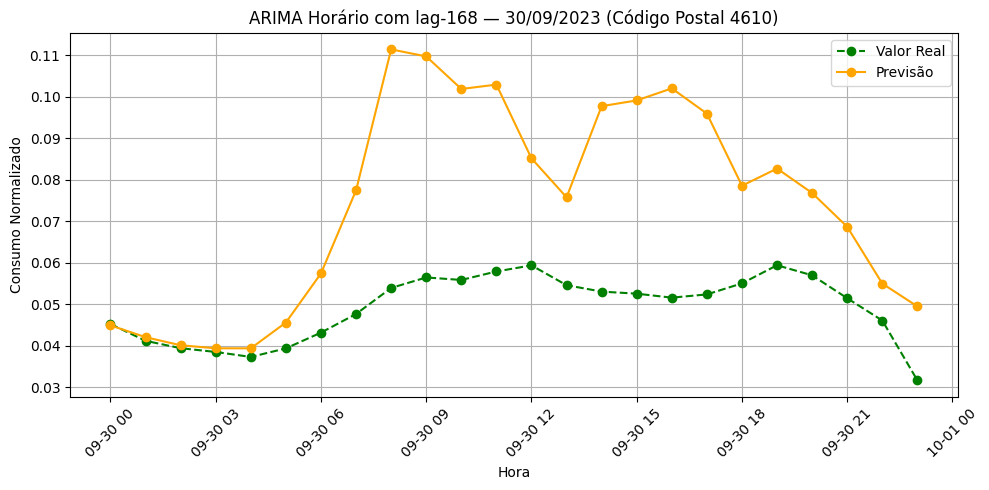

In [77]:
# valor real vs previsão
plt.figure(figsize=(10, 5))
plt.plot(y_true.index, y_true.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(y_pred.index, y_pred.values, marker='o', label='Previsão', color='orange')
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("ARIMA Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/arima_hourly_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
A utilização do ARIMA para prever o consumo energético **normalizado**, hora a hora, no dia **30/09/2023**, com base no valor da mesma hora da **semana anterior (`lag_168`)**, revelou um desempenho fraco. Apesar de o **MAE (0.025)** e o **RMSE (0.031)** parecerem baixos em valores absolutos, o **MAPE de 47.82%** indica que as previsões apresentam um erro percentual muito elevado, e o **R² fortemente negativo (−15.01)** confirma que o modelo foi incapaz de captar os padrões reais da série, sendo pior do que uma simples média constante. Este resultado mostra que, embora o `lag_168` capture a sazonalidade semanal, é claramente insuficiente por si só para modelar a complexidade e variabilidade do consumo energético em escala horária. A previsão horária requer, portanto, **modelos que suportem** lags adicionais de curto prazo e variáveis contextuais para melhorar a qualidade preditiva..

# Modelos ML & DL
# 📊RF

In [97]:
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Agregação diária: média de consumo e temperatura
daily = (
    df_cp
    .groupby("Date")
    .agg({
        "ActiveEnergy(kWh)": "mean",
        "Temperature": "mean"
    })
    .rename(columns={
        "ActiveEnergy(kWh)": "ActiveEnergyMean",
        "Temperature": "TempMeanDaily"
    })
    .reset_index()
)

# Junta as restantes features com base na 1ª ocorrência de cada dia
first_obs = df_cp.sort_values("DateTime").drop_duplicates("Date")
features_to_keep = ["Date","IsWeekend", "Season", "IsHoliday", "DayOfTheWeek", "Month", "TimeOfDay"]
daily = daily.merge(first_obs[features_to_keep], on="Date", how="left")

# Aplica o mapeamento no DataFrame `daily`
# Mapeamento de TimeOfDay (Manhã, Tarde, Noite)
map_season = {
    "Outono": 0.0,
    "Primavera": 1.0,
    "Verão": 2.0,
    "Inverno": 3.0
}
daily["Season"] = daily["Season"].map(map_season)

# Mapeamento de DayOfTheWeek (Segunda a Domingo)
map_day_of_week = {
    "Segunda": 0.0,
    "Terça": 1.0,
    "Quarta": 2.0,
    "Quinta": 3.0,
    "Sexta": 4.0,
    "Sábado": 5.0,
    "Domingo": 6.0
}
daily["DayOfTheWeek"] = daily["DayOfTheWeek"].map(map_day_of_week)

map_time_of_day = {
    "Manhã": 0.0,
    "Tarde": 1.0,
    "Noite": 2.0
}
daily["TimeOfDay"] = daily["TimeOfDay"].map(map_time_of_day)

# Cria lag_168 e remove nulos
daily["lag_168"] = daily["ActiveEnergyMean"].shift(7)
daily = daily.dropna(subset=["lag_168"]).copy()

# Converte Date para datetime (necessário para o split)
daily["Date"] = pd.to_datetime(daily["Date"])

# Split treino/teste
prediction_length = 7
last_date = daily["Date"].max().date()
mask_train = daily["Date"].dt.date <= (last_date - pd.Timedelta(days=prediction_length))

# Define features e targets
features = ["lag_168", "TempMeanDaily", "IsWeekend", "Season", "IsHoliday", "DayOfTheWeek", "Month", "TimeOfDay"]
X_train = daily.loc[mask_train, features]
y_train = daily.loc[mask_train, "ActiveEnergyMean"]
X_test  = daily.loc[~mask_train, features]
y_test  = daily.loc[~mask_train, "ActiveEnergyMean"]

#### 💾 (Opcional) Carregar um modelo existente

In [102]:
pipeline = load("./predicts/RF_daily/modelo/RF_pipeline.joblib")

#### 🛠️ Treinar

In [98]:
pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("lag7", StandardScaler(), ["lag_168"]),
        ("temp", StandardScaler(), ["TempMeanDaily"]),
        ("season", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Season"]),
        ("holiday", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["IsHoliday"]),
        ("weekend", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["IsWeekend"]),
        ("dayoftheweek", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["DayOfTheWeek"]),
        ("timeofday", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["TimeOfDay"]),
        ("month", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Month"])
    ], remainder="drop")),  # Mantém só o que for transformado explicitamente
    ("rf", RandomForestRegressor(
        n_estimators=100, random_state=123, n_jobs=-1))
])

pipeline.fit(X_train, y_train)

dump(pipeline, "predicts/RF_daily/modelo/RF_pipeline.joblib") # Guarda o modelo treinado.

['predicts/RF_daily/modelo/RF_pipeline.joblib']

#### 🔮 Previsão com os dados de treino

In [103]:
# Faz a previsão dos próximos 7 dias
y_pred = pipeline.predict(X_test)

#### 📊  Avaliação do modelo

In [104]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test) * 100).mean()
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  250.41723
MSE:  107395.48020
RMSE: 327.71250
MAPE: 2.58348%
R²:   0.97191


### 📊 **Métricas de Avaliação**

| Métrica                                   | Valor        | Interpretação                                                                            |
| ----------------------------------------- |--------------|------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)             | 250.41723    | Em média, a previsão do modelo erra cerca de 250 kWh em relação ao valor real.           |
| **MSE** (Erro Quadrático Médio)           | 107395.48020 | O erro médio ao quadrado é elevado, o que penaliza mais os erros grandes.                |
| **RMSE** (Raiz do Erro Quadrático Médio)  | 327.71250    | O erro médio da previsão é de aproximadamente 327 kWh, numa escala comparável ao target. |
| **MAPE** (Erro Percentual Absoluto Médio) | 2.58%        | Em média, o modelo comete um erro de 2.58% em relação ao valor real — um bom desempenho. |
| **R²** (Coeficiente de Determinação)      | 0.97191      | O modelo explica cerca de 97.19% da variabilidade do consumo energético diário.          |

#### 📈 Visualização dos resultados

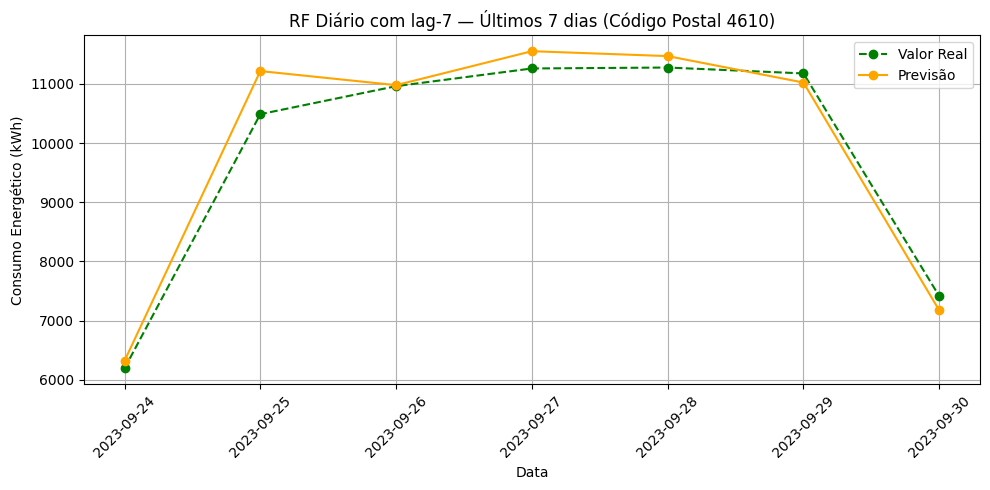

In [105]:
dates_test = daily.loc[~mask_train, "Date"]

plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_test.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(dates_test, y_pred, marker='o', label='Previsão', color='orange')
plt.xlabel("Data")
plt.ylabel("Consumo Energético (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("RF Diário com lag-7 — Últimos 7 dias (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("figuras/RF_daily_forecast.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
Com base nos resultados obtidos, o **Random Forest diário com lag-7** apresentou um desempenho **muito forte**, com um **R² de 0.97191**, indicando que é capaz de explicar **97.19% da variabilidade do consumo energético diário** no código postal 4610. O **MAPE de apenas 2.58%** confirma um nível de precisão bastante elevado, e os erros médios (MAE de \~250 kWh e RMSE de \~327 kWh) encontram-se num patamar competitivo e adequado à escala dos dados. No entanto, ao comparar com o modelo **ARIMA**, que obteve um **R² de 0.96791** e um **MAPE de 3.22%**, nota-se que o Random Forest supera ligeiramente o ARIMA em termos de **precisão e capacidade explicativa**. Além disso, o gráfico confirma uma sobreposição bastante próxima entre as previsões do Random Forest e os valores reais. Assim, conclui-se que, neste cenário, o modelo Random Forest não só iguala como **ultrapassa o ARIMA em desempenho**, sendo uma excelente escolha para a previsão diária do consumo energético.